# ViT training from scratch on Human Action Recognition Dataset

This this notebook, we implement Vision Transformer from scratch and train it on Human Action Recognition Dataset. The dataset is can be found on Kaggle: https://www.kaggle.com/datasets/shashankrapolu/human-action-recognition-dataset

In [1]:
import torch
import torch.nn as nn
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import numpy as np
from torchinfo import summary
from tqdm import tqdm
from einops import rearrange, repeat
from einops.layers.torch import Rearrange

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
imgs_path = Path("../../data/har/Structured/")
class_to_idx = {p.name: i for i, p in enumerate(list((imgs_path/ "train").iterdir()))}
idx_to_class = {v:k for k,v in class_to_idx.items()}

In [4]:
print(idx_to_class.values())

dict_values(['calling', 'clapping', 'cycling', 'dancing', 'drinking', 'eating', 'fighting', 'hugging', 'laughing', 'listening_to_music', 'running', 'sitting', 'sleeping', 'texting', 'using_laptop'])


In [5]:
class HumanActionDataset(Dataset):
    def __init__(self, imgs_path, transform = None) -> None:
        self.imgs_path = imgs_path
        self.transform = transform

        self.files_paths = [p for p in imgs_path.glob("**/*") if p.is_file()]

    def __len__(self):
        return len(self.files_paths)
    
    def __getitem__(self, index):
        file_path = self.files_paths[index]
        img = Image.open(file_path).convert('RGB')
        label = file_path.parent.name
        label = class_to_idx[label]

        if self.transform:
            img = self.transform(img)
        
        return img, label

In [6]:
def get_loaders(imgs_path, batch_size, val_split = 0.1, shuffle = True, random_seed=42):

    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        
    ])

    val_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    ])

    
    train_dataset = HumanActionDataset(imgs_path/ "train", train_transform)
    val_dataset = HumanActionDataset(imgs_path/ "train", val_transforms)
    test_dataset = HumanActionDataset(imgs_path/ "test", val_transforms)

    len_train = int(np.floor(len(train_dataset) * (1 - val_split)))
    len_val = len(train_dataset) - len_train

    indices = list(range(len(train_dataset)))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, val_idx = indices[:len_train], indices[len_train:]

    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)

    train_loader = DataLoader(train_dataset, batch_size, train_sampler)
    val_loader = DataLoader(val_dataset, batch_size, val_sampler)
    test_loader = DataLoader(test_dataset, batch_size)
                               
    return train_loader, val_loader, test_loader


Display images from the dataset

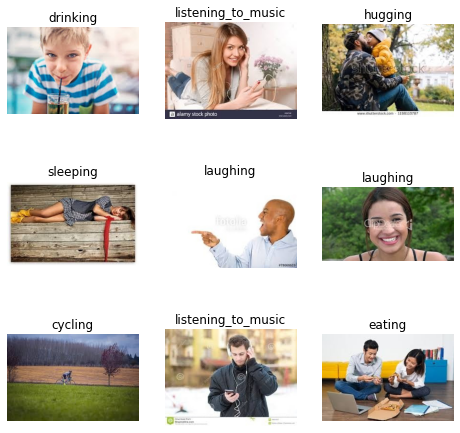

In [7]:
ds = HumanActionDataset(imgs_path/ "train")

figure = plt.figure(figsize=(8,8))
cols, rows = 3, 3
for i in range(1, rows * cols + 1):
    sample_idx = torch.randint(len(ds), size=(1,)).item()
    img, label = ds[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(idx_to_class[label])
    plt.axis("off")
    plt.imshow(img)

plt.show()

Create data loaders

In [8]:
batch_size = 32

In [9]:
train_loader, val_loader, test_loader = get_loaders(imgs_path, batch_size)

## Create Vision Transformer

In [10]:
def pair(t):
    return t if isinstance(t, tuple) else (t, t)

class PreNorm(nn.Module):
    def __init__(self, dim, fn) -> None:
        super().__init__()

        self.ln = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.ln(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim , hidden_dim, dropout=0) -> None:
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads=8, dim_head=64, dropout=0.) -> None:
        super().__init__()
        inner_dim = dim_head * heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(dropout)
    
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()


    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale
        attn = self.attend(dots)
        attn = self.dropout(attn)
        out= torch.matmul(attn, v)

        out = rearrange(out, 'b h n d -> b n (h d)')

        return self.to_out(out)


class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_heads, mlp_dim, dropout) -> None:
        super().__init__()

        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads=heads, dim_head=dim_heads, dropout=dropout)),
                PreNorm(dim, FeedForward(dim, hidden_dim=mlp_dim, dropout=dropout))
            ]))

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

class ViT(nn.Module):
    def __init__(self, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool='cls', channels=3, dim_heads=64, dropout=0., emb_dropout=0.) -> None:
        super().__init__()

        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'
    
        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width

        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_height, p2=patch_width),
            nn.Linear(patch_dim, dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_heads, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)
        
        x = self.transformer(x)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:,0]

        x = self.to_latent(x)

        return self.mlp_head(x) 


In [11]:
num_classes = len(class_to_idx)

In [12]:
model = ViT(
    image_size=224,
    patch_size=32,
    num_classes=num_classes,
    dim=768,
    depth=12,
    heads=12,
    mlp_dim=3072,
)

In [13]:
summary(model, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                             Output Shape              Param #
ViT                                                [1, 15]                   39,168
├─Sequential: 1-1                                  [1, 49, 768]              --
│    └─Rearrange: 2-1                              [1, 49, 3072]             --
│    └─Linear: 2-2                                 [1, 49, 768]              2,360,064
├─Dropout: 1-2                                     [1, 50, 768]              --
├─Transformer: 1-3                                 [1, 50, 768]              --
│    └─ModuleList: 2-3                             --                        --
│    │    └─ModuleList: 3-1                        --                        7,085,568
│    │    └─ModuleList: 3-2                        --                        7,085,568
│    │    └─ModuleList: 3-3                        --                        7,085,568
│    │    └─ModuleList: 3-4                        --                        7,085,

## Train model

In [14]:
num_epochs = 50
learning_rate = 0.001
weight_decay_rate = 0.005
momentum = 0.9

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay_rate, momentum=momentum)

In [16]:
total_steps = len(train_loader)

In [17]:
for epoch in range(num_epochs):
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    
    print(f"Epoch [{epoch+1}/{num_epochs}], loss: {loss.item():.4f}")

    with torch.no_grad():
        correct = 0
        total = 0
        for i, (images, labels) in enumerate(val_loader):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs.data, 1)

            correct += (preds == labels).sum()
            total += labels.size(0)

        acc = 100 * correct / total

    print(f"Validation accuracy: {acc:.2f}%")

Epoch [1/50], loss: 2.7536
Validation accuracy: 12.27%
Epoch [2/50], loss: 2.7470
Validation accuracy: 13.93%
Epoch [3/50], loss: 2.4704
Validation accuracy: 14.70%
Epoch [4/50], loss: 2.4037
Validation accuracy: 16.20%
Epoch [5/50], loss: 2.4476
Validation accuracy: 17.44%
Epoch [6/50], loss: 2.3663
Validation accuracy: 18.51%
Epoch [7/50], loss: 2.5759
Validation accuracy: 17.29%
Epoch [8/50], loss: 2.6471
Validation accuracy: 17.49%
Epoch [9/50], loss: 2.5549
Validation accuracy: 17.01%
Epoch [10/50], loss: 2.5161
Validation accuracy: 20.37%
Epoch [11/50], loss: 2.4268
Validation accuracy: 20.47%
Epoch [12/50], loss: 2.0690
Validation accuracy: 19.27%
Epoch [13/50], loss: 2.3821
Validation accuracy: 23.45%
Epoch [14/50], loss: 2.2793
Validation accuracy: 25.35%
Epoch [15/50], loss: 2.4792
Validation accuracy: 26.55%
Epoch [16/50], loss: 1.8471
Validation accuracy: 25.28%
Epoch [17/50], loss: 2.2393
Validation accuracy: 28.40%
Epoch [18/50], loss: 2.3848
Validation accuracy: 24.01%
E

In [18]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del images, labels, outputs

    print(f'Test accuracy: {100 * correct / total:.2f} %')

Test accuracy: 31.43 %
